In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    # 평모스 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n
    
    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
    # 투자 비중이 모두 0인 구간에서는 현금 보유
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)
    
    # 투자비중, 평모스 리턴
    return weight, avgMomentumScore

## 영구 포트폴리오

모든 경제상황에서도 잘 견디도록 만들어진 정적자산배분 투자법

참고자료  

https://www.youtube.com/watch?v=2BkZZNnlCHA&t=121s  


장점
- 각 자산군에 동일 비중으로 분산되어 MDD가 낮은편

단점
- 주식 비중이 낮고 현금성 자산 비중이 높은편이라 MDD는 높지만, 수익률은 조금 아쉬움.


---

투자전략

주식: 25%, (VTI 미국 전체 주식)  
채권 25%, (TLT 미국 장기채)  
현금 또는 단기채 25%, 단기 채권 (SHY 미 단기채)  
금 25%  (GLD)  
월별 / 분기별 / 연별 리밸런싱

In [2]:
# 데이터 준비
closeDataSet = pd.read_csv("./정적자산배분데이터.csv", index_col=0, parse_dates=True)
closeDataSet

,VTI,VBR,TLT,IEF,IEI,SHY,GSG,GLD
2010-01-04,46.08189,55.52,66.13332,71.24535,94.21502,75.39010,32.70,109.80
2010-01-05,46.25879,55.46,66.56042,71.55817,94.51414,75.48085,33.03,109.70
2010-01-06,46.32312,55.55,65.66942,71.26941,94.38595,75.48993,33.27,111.51
2010-01-07,46.51610,56.04,65.77987,71.26941,94.35176,75.47178,33.11,110.82
2010-01-08,46.66887,56.24,65.75042,71.35764,94.48850,75.54438,33.18,111.37
...,...,...,...,...,...,...,...,...
2022-07-27,200.86000,160.25,116.82000,104.10000,120.49000,82.88000,22.86,161.67
2022-07-28,203.48000,162.72,117.75000,105.13000,121.23000,83.06000,22.79,163.64
2022-07-29,206.25000,164.54,117.43000,105.17000,121.26000,83.05000,22.93,164.10
2022-08-01,205.77000,164.45,120.04000,105.60000,121.30000,82.96000,22.25,165.03


In [3]:
perCol = ['VTI', "TLT", "SHY", "GLD"]
perData = closeDataSet[perCol]
perData = perData.loc['2010-12-31':]
perData

,VTI,TLT,SHY,GLD
2010-12-31,53.22560,72.15820,77.00478,138.72
2011-01-03,53.77483,71.61387,76.98643,138.00
2011-01-04,53.66826,71.69820,76.96809,134.75
2011-01-05,53.96337,70.11887,76.83055,134.37
2011-01-06,53.84040,70.42554,76.91307,133.83
...,...,...,...,...
2022-07-27,200.86000,116.82000,82.88000,161.67
2022-07-28,203.48000,117.75000,83.06000,163.64
2022-07-29,206.25000,117.43000,83.05000,164.10
2022-08-01,205.77000,120.04000,82.96000,165.03


In [4]:
# 영구 weightDf 만들기
rebalDate = getRebalancingDate(perData)
perWeight = [0.25, 0.25, 0.25, 0.25]
perWeightDf = pd.DataFrame([perWeight] * len(rebalDate), index = rebalDate)
perWeightDf.columns = perCol
perWeightDf

,VTI,TLT,SHY,GLD
2010-12-31,0.25,0.25,0.25,0.25
2011-01-31,0.25,0.25,0.25,0.25
2011-02-28,0.25,0.25,0.25,0.25
2011-03-31,0.25,0.25,0.25,0.25
2011-04-29,0.25,0.25,0.25,0.25
...,...,...,...,...
2022-04-29,0.25,0.25,0.25,0.25
2022-05-31,0.25,0.25,0.25,0.25
2022-06-30,0.25,0.25,0.25,0.25
2022-07-29,0.25,0.25,0.25,0.25


In [5]:
# 월별 리밸런싱 영구 포트폴리오 성과
monthDayReturn, monthCumReturn = getRebalancingPortfolioResult(closeDataSet=perData, weightDf=perWeightDf)
monthCAGR, monthDD, monthMDD = getEvaluation(monthCumReturn)

최종 수익률: 1.796085416435175
cagr: 1.0519107063481334
mdd: 14.696122010261044


In [6]:
# 분기별 리밸런싱 영구 포트폴리오 성과
quarterDayReturn, quarterCumReturn = getRebalancingPortfolioResult(closeDataSet=perData, period="quarter", weightDf=perWeightDf)
quarterCAGR, quarterDD, quarterMDD = getEvaluation(quarterCumReturn)

최종 수익률: 1.7829069644065723
cagr: 1.0516408789411404
mdd: 14.55231065004983


In [7]:
# 연별 리밸런싱 영구 포트폴리오 성과
yearDayReturn, yearCumReturn = getRebalancingPortfolioResult(closeDataSet=perData, period="year", weightDf=perWeightDf)
yearCAGR, yearDD, yearMDD = getEvaluation(yearCumReturn)

최종 수익률: 1.7853074708915124
cagr: 1.0513636975932288
mdd: 14.248612288174487


In [8]:
# VTI 시장 수익률
stockCumReturn = getCumulativeReturn(perData['VTI'])
stockCAGR, stockDD, stockMDD = getEvaluation(stockCumReturn)

최종 수익률: 3.8451421872181806
cagr: 1.1234350920121918
mdd: 35.000279625753635


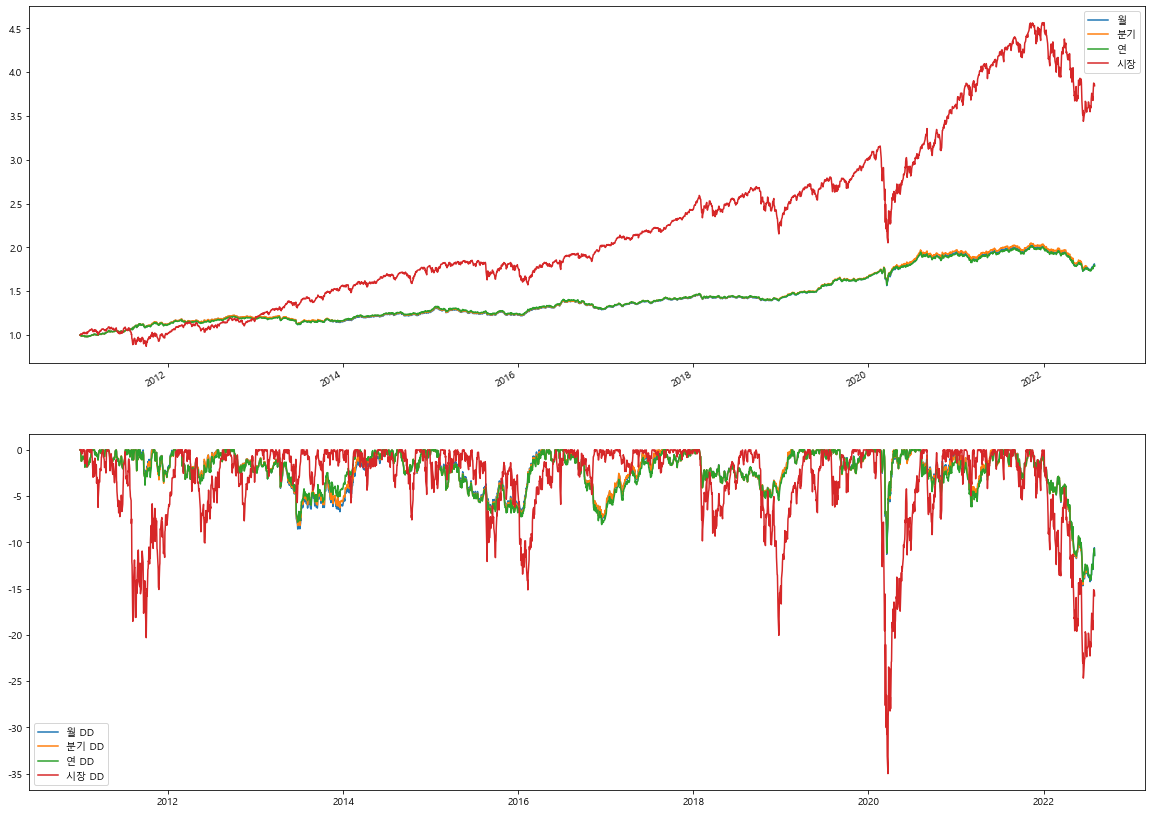

In [9]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
monthCumReturn.plot(label="월")
quarterCumReturn.plot(label="분기")
yearCumReturn.plot(label="연")
stockCumReturn.plot(label="시장")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(-monthDD, label="월 DD")
plt.plot(-quarterDD, label="분기 DD")
plt.plot(-yearDD, label="연 DD")
plt.plot(-stockDD, label="시장 DD")
plt.legend()

plt.show()

**영구 포트폴리오 자산을 다르게 해본다면? - 국내 ETF**

* 주식(25%)
    * 선진국 주식(12.5%): KODEX 미국 S&P500선물(H)
    * 개도국 주식(12.5%): KODEX 200
* 채권(25%)
    * 미국 장기채(12.5%):KODEX 미국채울트라30년선물(H)
    * 미국 중기채(12.5%):TIGER 미국채10년선물(H)
* 금(25%)
    * KINDEX KRX금현물
* 현금(25%)